In [1]:
import cupy as cp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import os
import pickle
import sys


sys.path.append(os.path.join(os.getenv("HOME"), "gpuaffman_networks/"))
import general_network_visualization
from genetics import analysis_util, tasks

In [2]:
plt_save_dir = "/home/trevor/boolean_network_data/plots_and_misc_material"


In [3]:
data_path = "boolean_network_data/pnas_evolution_results/2023-03-08-13-28-06/batch_1.npz"
data = np.load(os.path.join(os.getenv("DATA_DIR"), data_path))

In [4]:
N = data["N"]
input_state = cp.asnumpy(tasks.make_4_bit_input_state(N))
best_functions = np.expand_dims(data["functions"], 1)
best_conn = np.expand_dims(data["connectivity"], 1)
best_used_conn = np.expand_dims(data["used_connectivity"], 1)
batched_input_state = np.broadcast_to(np.expand_dims(np.expand_dims(input_state, 1), 1), (input_state.shape[0], np.shape(best_functions)[0], 1, N)).astype(np.bool_)

In [5]:
best_functions, best_conn, best_used_conn, sorted_perfs =  analysis_util.sort_by_performance(cp.array(batched_input_state), cp.array(best_functions), cp.array(best_conn), cp.array(best_used_conn), tasks.evaluate_pnas_task, n_trajectories=2000)

In [6]:
import importlib
importlib.reload(general_network_visualization)
graphs = [general_network_visualization.influence_graph_from_ragged_spec(f[0, :, :], c[0, :, :], uc[0, :, :]) for f, c, uc in zip(cp.asnumpy(best_functions), cp.asnumpy(best_conn), cp.asnumpy(best_used_conn))]
[g.remove_nodes_from(list(nx.isolates(g))) for g in graphs]
[g.remove_nodes_from(list(nx.isolates(g))) for g in graphs]
[general_network_visualization.prune_non_participating(g, [0, 1, 2, 3, 4]) for  g in graphs]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

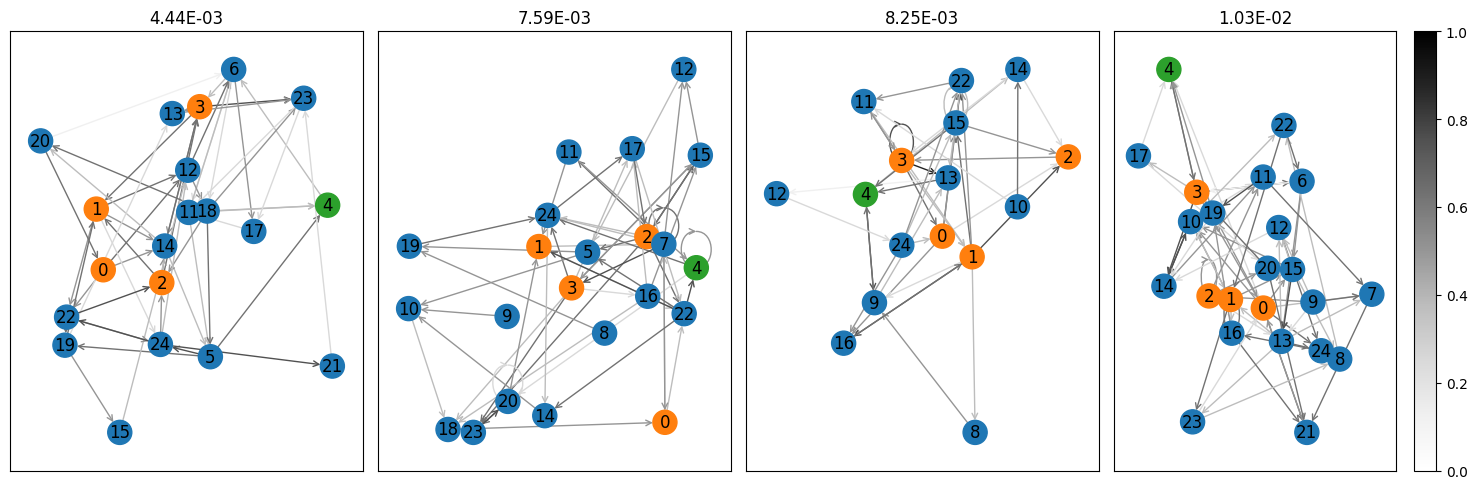

In [8]:
import importlib
importlib.reload(general_network_visualization)
best_to_plot = 4
to_plot = graphs[:best_to_plot]
fig, axs = plt.subplots(ncols=len(to_plot), figsize=(15,5))
node_colors = ["C0"] * int(N)
node_colors[0] = "C1"
node_colors[1] = "C1"
node_colors[2] = "C1"
node_colors[3] = "C1"
node_colors[4] = "C2"




for i, (g, ax, err) in enumerate(zip(graphs, axs, sorted_perfs[:best_to_plot])):
    pos = nx.spring_layout(g, iterations=10)
    colorbar = True if i==best_to_plot-1 else False
    general_network_visualization.plot_network_directed(g, pos, ax, node_colors[:len(g.nodes)], colorbar=colorbar)
    ax.set_title("{:.2E}".format(err))
fig.tight_layout()
plt.savefig(os.path.join(plt_save_dir, "sequential_and_organisms.png"), dpi=400)

In [9]:
influence = analysis_util.compute_influence(cp.asnumpy(best_functions[:2, 0, ...]))

In [13]:
importlib.reload(analysis_util)
example_trajs, example_noise = analysis_util.run_dynamics_forward_save_state(cp.array(batched_input_state), best_functions, best_conn, best_used_conn, 10, 0)
example_trajs = np.squeeze(example_trajs, -2)
example_noise = np.squeeze(example_noise, -2)

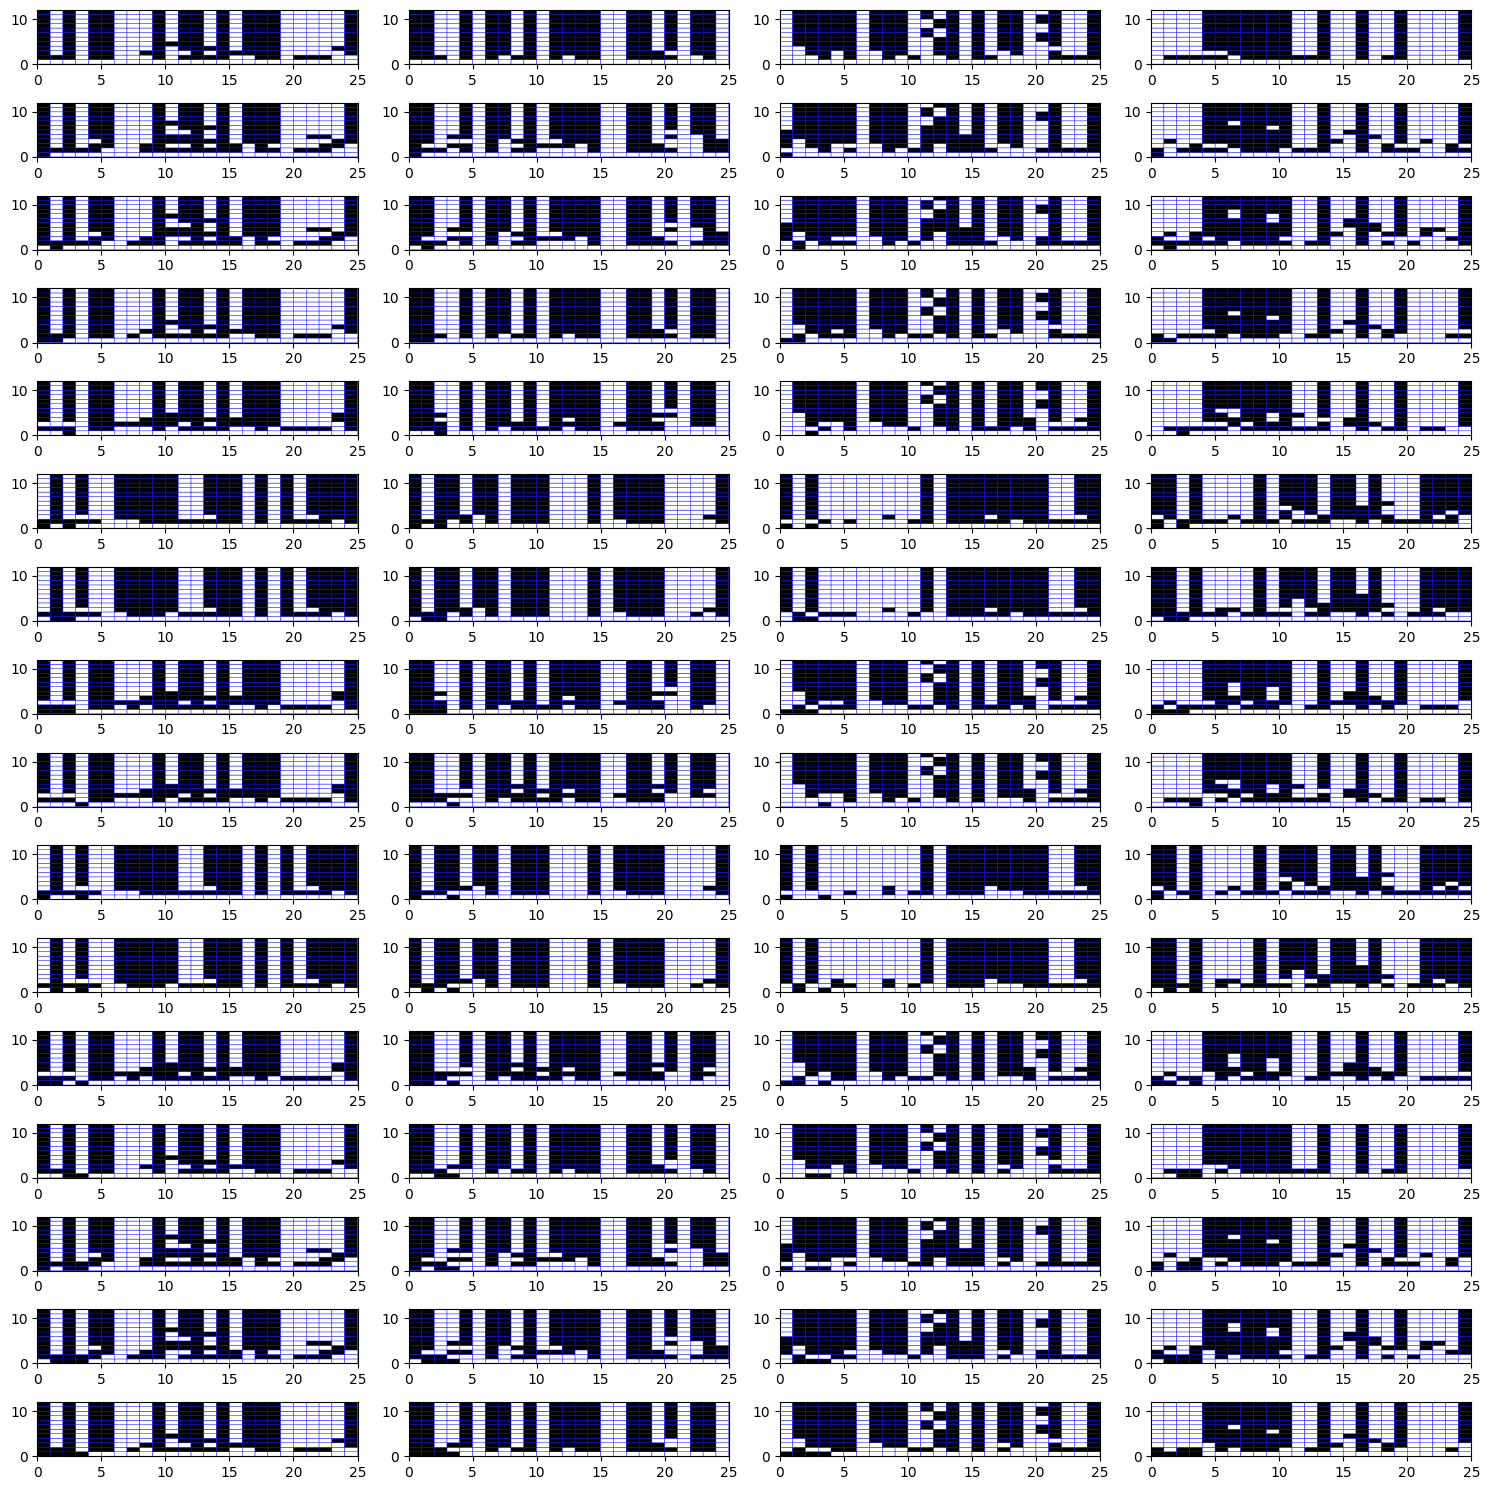

In [14]:
to_plot = list(range(16))
fig, axs = plt.subplots(nrows=len(to_plot), ncols=best_to_plot, figsize=(15, 15))
for i in range(best_to_plot):
    for j, k in enumerate(to_plot):
        axs[j, i].pcolor(cp.asnumpy(example_trajs[:, k, i, :]), cmap="Greys", linewidth=0.3, edgecolors="blue")
fig.tight_layout()

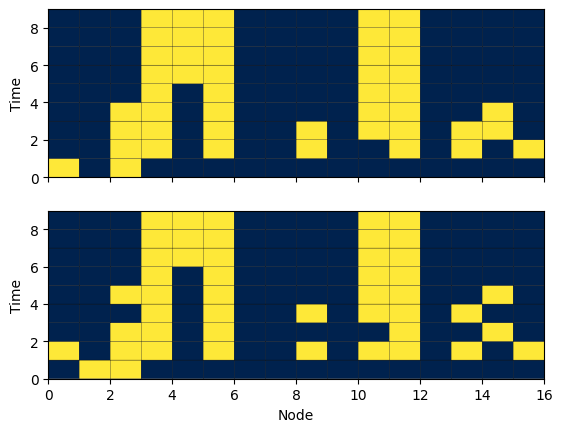

In [43]:
fig, axs = plt.subplots(nrows=2, sharey=True, sharex=True)
lw = 0.2
cm = "cividis"
axs[0].pcolor(cp.asnumpy(example_trajs[:, -3, 0, :]), cmap=cm, linewidth=lw, edgecolors="black")
axs[1].pcolor(cp.asnumpy(example_trajs[:, -2, 0, :]), cmap=cm, linewidth=lw, edgecolors="black")
axs[-1].set_xlabel('Node')


[axs[i].set_ylabel('Time') for i in range(2)]
plt.savefig(os.path.join(plt_save_dir, "sequential_and_traj.png"), dpi=400)

In [29]:
physical_error_rates = np.linspace(start=0, stop=0.03, num=20)
logical_error_rates = analysis_util.generate_ft_curve(physical_error_rates, cp.array(batched_input_state), cp.array(best_functions), cp.array(best_conn), cp.array(best_used_conn), tasks.evaluate_sequential_and_task, n_traj=15000)
logical_error_rates = cp.asnumpy(logical_error_rates)

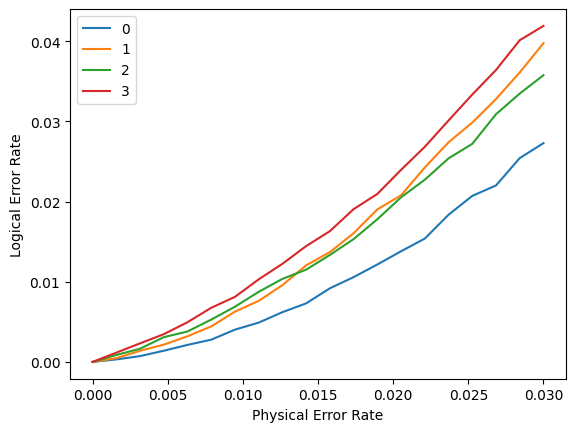

In [44]:
fig, axs = plt.subplots()
logical_error_rates = np.array(logical_error_rates)
for j in range(best_to_plot):
    axs.plot(physical_error_rates, logical_error_rates[:, j], label="{}".format(j))
axs.set_xlabel("Physical Error Rate")
axs.set_ylabel("Logical Error Rate")
axs.legend()

plt.savefig(os.path.join(plt_save_dir, "shared_and_ft.png"), dpi=400)
